# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks
daily_returns=df.pct_change()
# Display sample data
daily_returns.sample()

,AGG,SPY
,close,close
2019-08-28 00:00:00-04:00,0.000175,0.006973


In [7]:
# Compute daily volatility
daily_volatility=daily_returns.std()
daily_volatility

AGG  close    0.00209
SPY  close    0.00782
dtype: float64

In [8]:
daily_volatility_agg = daily_volatility["AGG"]["close"]

In [9]:
daily_volatility_agg

0.002089826211646555

In [10]:
daily_volatility_spy = daily_volatility["SPY"]["close"]

In [11]:
daily_volatility_spy

0.007820053413439366

In [12]:
avg_dly_rtrn_agg=daily_returns["AGG"]["close"].mean()

In [13]:
avg_dly_rtrn_agg

0.00021277231473764173

In [14]:
avg_dly_rtrn_spy=daily_returns["SPY"]["close"].mean()

In [15]:
avg_dly_rtrn_spy

0.0010401250682146959

In [16]:
# Save the last day's closing price
last_day_close_agg=df["AGG"]["close"][-1]
last_day_close_agg

112.37

In [17]:
last_day_close_spy=df["SPY"]["close"][-1]
last_day_close_spy

321.92

In [18]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
simulated_price_df=pd.DataFrame()
portfolio_cumulative_returns=pd.DataFrame()

In [19]:
# Run the Monte Carlo Simulation
for simulations in range(number_simulations):
    simulated_agg_prices=[last_day_close_agg]
    simulated_spy_prices=[last_day_close_spy]
    for days in range(number_records):
        simulated_agg_price=simulated_agg_prices[-1]*(1+np.random.normal(avg_dly_rtrn_agg,daily_volatility_agg))
        simulated_spy_price=simulated_spy_prices[-1]*(1+np.random.normal(avg_dly_rtrn_spy,daily_volatility_spy))
        
        simulated_agg_prices.append(simulated_agg_price)
        simulated_spy_prices.append(simulated_spy_price)
    
    simulated_price_df["AGG"]=simulated_agg_prices
    simulated_price_df["SPY"]=simulated_spy_prices
    
    simulated_daily_returns=simulated_price_df.pct_change()
    weights=[0.40,0.60]
    portfolio_daily_returns=simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[simulations]= (1+portfolio_daily_returns.fillna(0)).cumprod()
    

In [20]:
# Check that the simulation ran successfully
simulated_price_df.head()

,AGG,SPY
0,112.370000,321.920000
1,112.404907,323.812762
2,112.491876,327.912049
3,112.493958,329.682152
4,112.009587,331.177063


In [21]:
# Visualize the Simulation
portfolio_cumulative_returns.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
7556,252.220626,144.313297,238.456334,155.374776,197.248702,336.845060,188.200560,144.936078,390.111322,282.170932,...,289.210659,191.806174,257.270497,203.008852,191.459625,252.905181,175.251524,230.267739,140.429671,133.750073
7557,251.095225,144.515573,239.336452,155.390539,198.564961,336.310446,189.251886,143.412550,391.932603,281.946759,...,289.884258,192.517197,258.143700,201.752420,191.966861,252.375876,176.368491,229.277674,141.139644,133.659605
7558,249.602325,145.571530,239.525529,155.518039,198.636318,336.590575,188.560588,141.991815,390.884001,281.846894,...,288.805336,193.129312,259.018383,199.971128,192.004218,253.288609,176.257066,228.831976,140.541865,133.783692
7559,250.409370,145.499374,238.187051,154.912704,198.936059,337.305266,188.702620,142.565296,392.673903,282.485517,...,287.914838,193.219551,259.798143,201.316916,191.400557,252.617944,174.997027,228.441161,141.565297,134.343282
7560,249.154646,145.745888,237.137409,156.037899,197.718620,335.590503,188.746598,142.610675,395.382302,279.591383,...,288.805945,194.636167,260.245374,201.375008,190.481127,253.431006,175.103433,228.207256,142.088499,134.196132


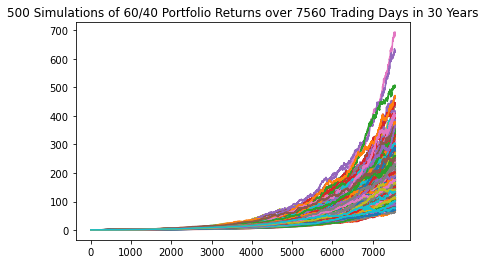

In [22]:
plot_title=f"{number_simulations} Simulations of 60/40 Portfolio Returns over {number_records} Trading Days in 30 Years"
portfolio_cumulative_returns.plot(legend=None,title=plot_title)

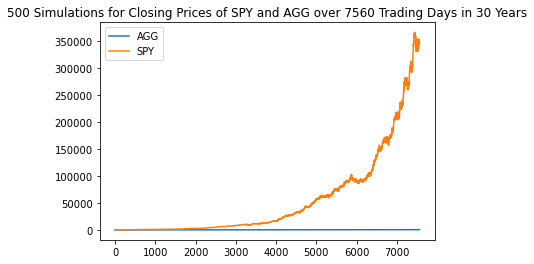

In [23]:
plot_title2=f"{number_simulations} Simulations for Closing Prices of SPY and AGG over {number_records} Trading Days in 30 Years"
simulated_price_df.plot(title=plot_title2)

In [24]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
simulated_price_df[-1:]

,AGG,SPY
7560,567.567685,348437.552398


In [25]:
cumulative_ret = portfolio_cumulative_returns.iloc[-1,:]
cumulative_ret

0      249.154646
1      145.745888
2      237.137409
3      156.037899
4      197.718620
          ...    
495    253.431006
496    175.103433
497    228.207256
498    142.088499
499    134.196132
Name: 7560, Length: 500, dtype: float64

In [26]:
# Display the 90% confidence interval for the ending returns
confidence_interval= cumulative_ret.quantile(q=[0.05,0.95])
confidence_interval

0.05     98.266707
0.95    366.936857
Name: 7560, dtype: float64

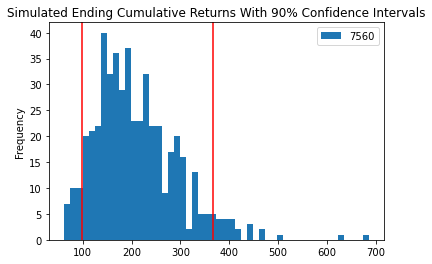

In [27]:
# Visualize the distribution of the ending returns
cumulative_ret.plot.hist(legend=True,bins=50, title="Simulated Ending Cumulative Returns With 90% Confidence Intervals")
plt.axvline(confidence_interval.iloc[0],color='r')
plt.axvline(confidence_interval.iloc[1],color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

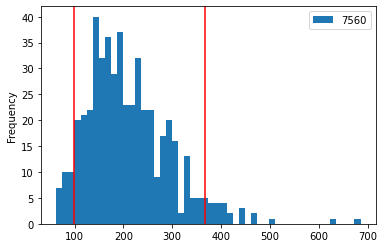

In [28]:
# Compute cumulative returns
cumulative_ret.plot.hist(legend=True,bins=50)
plt.axvline(confidence_interval.iloc[0],color='r')
plt.axvline(confidence_interval.iloc[1],color='r')

In [29]:
cum_90_perct = cumulative_ret.quantile(0.9)

In [30]:
print(f"The expected cumulative returns at 30 years for the 90'th percentile is {round(cum_90_perct,2)}")

The expected cumulative returns at 30 years for the 90'th percentile is 319.65


In [31]:
confidence_interval_50 = cumulative_ret.quantile(q=[0.25,0.75])

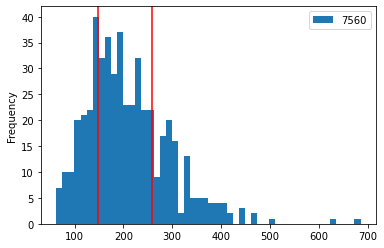

In [32]:
cumulative_ret.plot.hist(legend=True,bins=50)
plt.axvline(confidence_interval_50.iloc[0],color='r')
plt.axvline(confidence_interval_50.iloc[1],color='r')

In [33]:
cum_50_perct = cumulative_ret.quantile(0.5)

In [34]:
print(f"The expected cumulative returns at 30 years for the 50'th percentile is {round(cum_50_perct,2)}")

The expected cumulative returns at 30 years for the 50'th percentile is 194.85


In [35]:
confidence_interval_tenth= cumulative_ret.quantile(q=[0.1,0.9])

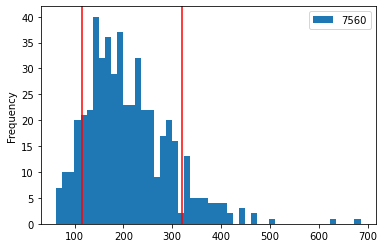

In [36]:
cumulative_ret.plot.hist(legend=True,bins=50)
plt.axvline(confidence_interval_tenth.iloc[0],color='r')
plt.axvline(confidence_interval_tenth.iloc[1],color='r')

In [37]:
cum_10_perct = cumulative_ret.quantile(0.1)

In [38]:
print(f"The expected cumulative returns at 30 years for the 10'th percentile is {round(cum_10_perct,2)}")

The expected cumulative returns at 30 years for the 10'th percentile is 114.2


In [39]:
cum_10_perct

114.19660573056179

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [40]:
# Set initial investment
investment=20000
returns_10th=investment*cum_10_perct
# Compute expected portfolio return
returns_10th

2283932.114611236

In [41]:
returns_50th=investment*cum_50_perct

In [42]:
returns_50th

3897086.228749309

In [43]:
returns_90th=investment*cum_90_perct

In [44]:
returns_90th

6393052.330014319

In [45]:
print(f"""With an initial investment of $20,000.00 the expected returns in dollars at the 10th, 50th, and 90th percentiles would be as follows:

10th Percentile: ${round(returns_10th,2)}

50th Percentile: ${round(returns_50th,2)}

90th Percentile: ${round(returns_90th,2)}""")

With an initial investment of $20,000.00 the expected returns in dollars at the 10th, 50th, and 90th percentiles would be as follows:

10th Percentile: $2283932.11

50th Percentile: $3897086.23

90th Percentile: $6393052.33


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [46]:
# Set Plaid's projected income

income_response=client.Income.get(access_token)
projected_yearly_income=income_response["Income"]
# Calculate the 4% withdrawal for the ending return as retirement income
retirement_income=0.04*(projected_yearly_income*cum_10_perct)
# Determine if the retirement income meets or exceeds the current projected income
rate_2=0.04*(investment*cum_10_perct)
rate_2

NameError: name 'client' is not defined

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [ ]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# Compute projected returns

# Display sample data


In [ ]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
